In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/utkface-new/UTKFace/26_0_2_20170104023102422.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/22_1_1_20170112233644761.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/21_1_3_20170105003215901.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/28_0_0_20170117180555824.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/17_1_4_20170103222931966.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/44_0_3_20170119201022260.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/35_0_2_20170116182734834.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/76_0_0_20170104213515132.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/36_1_0_20170116165722892.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/34_0_3_20170119200815948.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/18_1_0_20170104022856102.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/40_1_1_20170113011948248.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/45_0_0_20170117180013541.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/26_1_1_20170117153641469.jpg.c

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [10]:
ages = []
genders = []
images = []


filedr = '/kaggle/input/utkface-new/UTKFace'
files = os.listdir(filedr)

for fl in files:
    age = int(fl.split('_')[0])
    gender = int(fl.split('_')[1])
    total = os.path.join(filedr, fl)
    image = cv2.imread(total)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))
    images.append(image)
    ages.append(age)
    genders.append(gender)

In [11]:
images_f = np.array(images)
ages_f = np.array(ages)
genders_f = np.array(genders)


In [12]:
images_f = images_f / 255.0

In [13]:
np.save('/kaggle/working/image.npy', images_f)
np.save('/kaggle/working/ages.npy', ages_f)
np.save('/kaggle/working/genders.npy', genders_f)

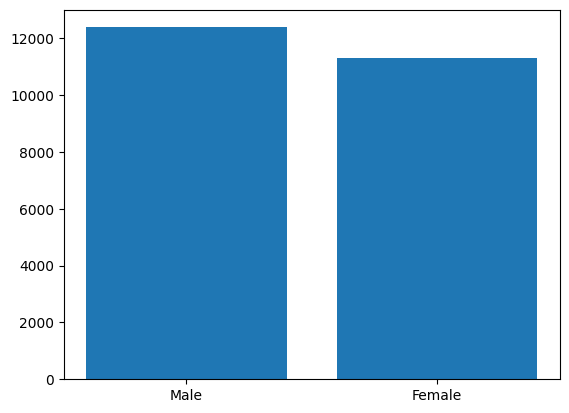

In [14]:
unique_genders, gender_counts = np.unique(genders_f, return_counts=True)
plt.bar(['Male', 'Female'], gender_counts)
plt.show()


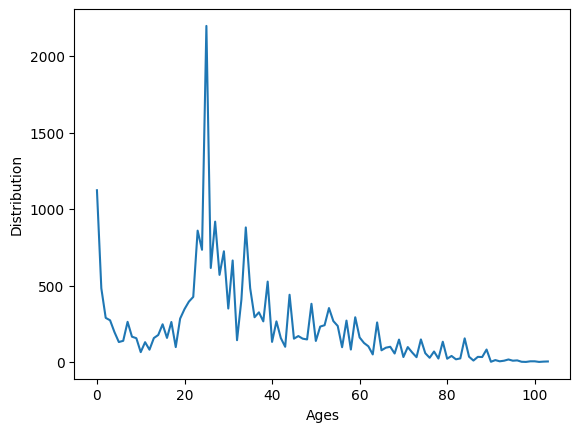

In [15]:
unique_ages, age_counts = np.unique(ages_f, return_counts=True)
plt.plot(age_counts)
plt.xlabel("Ages")
plt.ylabel('Distribution')
plt.show()

In [16]:
labels = np.column_stack((ages_f, genders_f))
X_train, X_test, Y_train, Y_test = train_test_split(images_f, labels, test_size=0.25, random_state=42)
Y_train_age, Y_train_gender = Y_train[:, 0], Y_train[:, 1]
Y_test_age, Y_test_gender = Y_test[:, 0], Y_test[:, 1]

In [17]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), padding="same", kernel_regularizer=l2(0.001))(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output_gender = Dense(1, activation='sigmoid', name='gender_output')(x)
    output_age = Dense(1, activation='linear', name='age_output')(x)
    
    model = Model(inputs=inputs, outputs=[output_gender, output_age])
    model.compile(optimizer='RMSprop',
                  loss={'gender_output': 'binary_crossentropy', 'age_output': 'mae'},
                  metrics={'gender_output': 'accuracy', 'age_output': 'mse'})
    
    return model


In [18]:
input_shape = (48, 48, 3)
model_ag = build_model(input_shape)
model_ag.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 24, 24,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 6, 256) │    295,168 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 3, 3, 256) │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2304)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    147,520 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 536,066 (2.04 MB)

 Trainable params: 536,066 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint_path = 'Age_Sex_Detection.keras'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_gender_output_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
early_stop = EarlyStopping(patience=10,
                           monitor='val_gender_output_accuracy',
                           restore_best_weights=True,
                           mode='max')
callbacks = [checkpoint, early_stop]

# Train model
history = model_ag.fit(
    X_train, 
    {'gender_output': Y_train_gender, 'age_output': Y_train_age},
    validation_data=(X_test, {'gender_output': Y_test_gender, 'age_output': Y_test_age}),
    epochs=50,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - age_output_mse: 650.4229 - gender_output_accuracy: 0.4980 - loss: 20.9441
Epoch 1: val_gender_output_accuracy improved from -inf to 0.63742, saving model to Age_Sex_Detection.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 65s 455ms/step - age_output_mse: 649.6381 - gender_output_accuracy: 0.4981 - loss: 20.9300 - val_age_output_mse: 421.1618 - val_gender_output_accuracy: 0.6374 - val_loss: 16.1127
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - age_output_mse: 465.6394 - gender_output_accuracy: 0.5116 - loss: 17.3947
Epoch 2: val_gender_output_accuracy did not improve from 0.63742
139/139 ━━━━━━━━━━━━━━━━━━━━ 61s 440ms/step - age_output_mse: 465.5999 - gender_output_accuracy: 0.5117 - loss: 17.3934 - val_age_output_mse: 481.3771 - val_gender_output_accuracy: 0.6251 - val_loss: 16.9850
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - age_output_mse: 433.4554 - gender_output_accuracy: 0.5743 - loss: 16.5374
Epoch 3: val_gender_ou

In [21]:
from tensorflow.compat.v1 import reset_default_graph

# Resetting default graph as per deprecation warning
reset_default_graph()

In [24]:
evaluation = model_ag.evaluate(X_test, {'gender_output': Y_test_gender, 'age_output': Y_test_age})
print(f"Test loss: {evaluation[0]}\nGender accuracy: {evaluation[1]}\nAge MAE: {evaluation[2]}")

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - age_output_mse: 89.3479 - gender_output_accuracy: 0.8920 - loss: 7.5141
Test loss: 7.525144577026367
Gender accuracy: 89.83904266357422
Age MAE: 0.8866205215454102


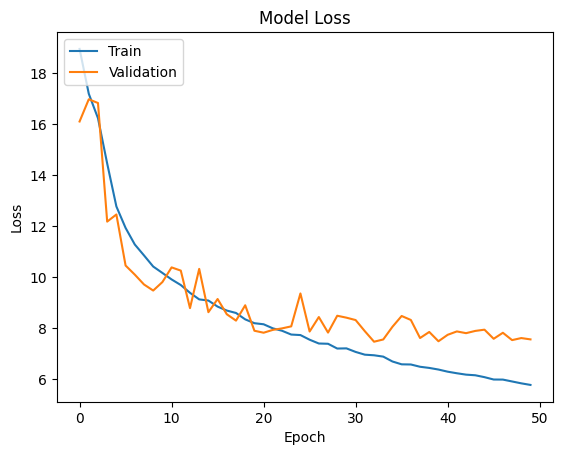

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

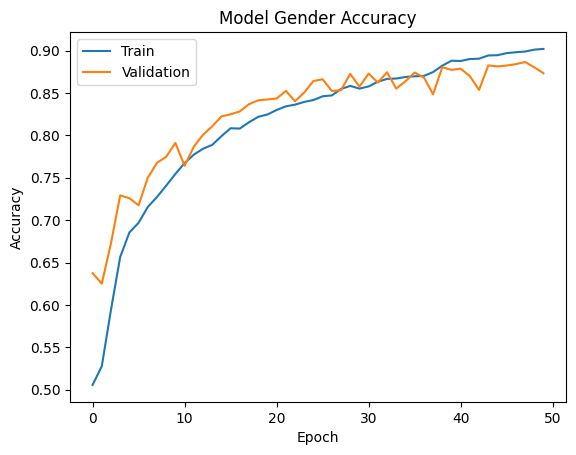

In [26]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Model Gender Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


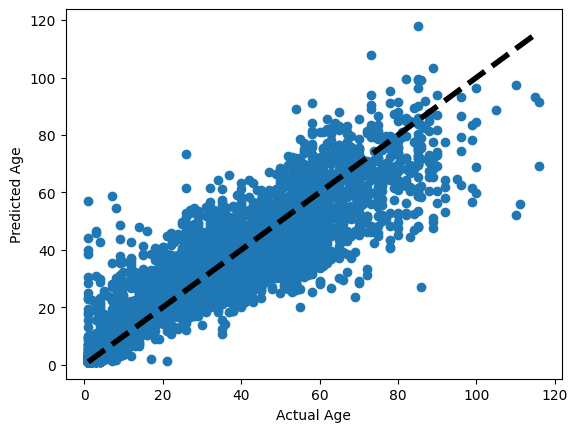

In [27]:
plt.scatter(Y_test_age, model_ag.predict(X_test)[1])
plt.plot([Y_test_age.min(), Y_test_age.max()], [Y_test_age.min(), Y_test_age.max()], 'k--', lw=4)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()


In [28]:
gender_pred = np.round(model_ag.predict(X_test)[0]).astype(int)
gender_report = classification_report(Y_test_gender, gender_pred)
print(gender_report)

186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3113
           1       0.90      0.86      0.88      2814

    accuracy                           0.89      5927
   macro avg       0.89      0.89      0.89      5927
weighted avg       0.89      0.89      0.89      5927



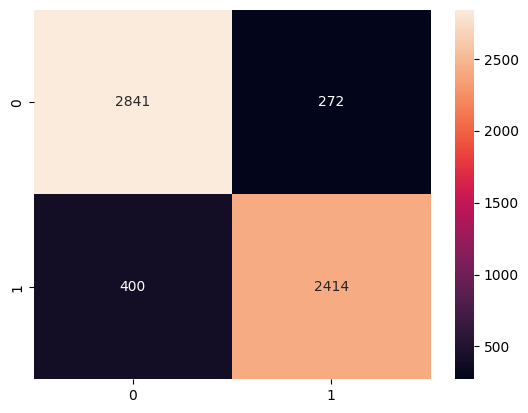

In [31]:
conf_matrix = confusion_matrix(Y_test_gender, gender_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Age: 71
Predicted Gender: Male
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Age: 77
Predicted Gender: Female
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Age: 27
Predicted Gender: Female
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Age: 18
Predicted Gender: Female


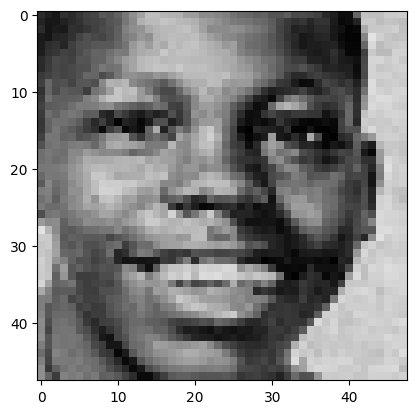

In [33]:
def test_image(index, images, normalized_images, model):
    plt.imshow(images[index])
    image_test = normalized_images[index]
    pred = model.predict(np.array([image_test]))
    age_pred = int(np.round(pred[1][0, 0]))
    gender_pred = int(np.round(pred[0][0, 0]))
    gender_label = 'Male' if gender_pred == 1 else 'Female'
    print(f"Predicted Age: {age_pred}")
    print(f"Predicted Gender: {gender_label}")
    
test_image(45, images, images_f, model_ag)
test_image(123, images, images_f, model_ag)
test_image(543, images, images_f, model_ag)
test_image(2343, images, images_f, model_ag)